In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
#train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)

In [6]:
batch_size = 50
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [7]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [9]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [10]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 32
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        
        self.latent_fn = nn.Sigmoid()
                    
        self.fce = FullyConnected([32*2*2, self.latent_size])
        self.fcd = FullyConnected([self.latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([32, 128, 128, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
       
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.latent_fn(self.fce(flatten))
        return h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x):
        self.h = self.encode(x)
        x = self.decode(self.h)
        return x
    
    def loss(self, output, target):
        
        encoded = self.encode(target)        
        fake_pred = self.discriminator(encoded)        
             
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)        
        self.discr_loss = fake_loss
            
        self._loss = F.mse_loss(output, target) + self.discr_loss
        
        return self._loss

In [11]:
# models = {'SGD': Net(False, False, 'SGD', lr=1e-4),
#           'momentum': Net(False, False, 'SGD', lr=1e-4, momentum=0.9),
#           'RMSProp': Net(False, False, 'RMSProp', lr=1e-4),
#           'RMSProp+bn': Net(True, False, 'RMSProp', lr=1e-4),
#           'Adam': Net(False, False, 'Adam', lr=1e-4), 
#           'Adam+bn': Net(True, False, 'Adam', lr=1e-4), 
#          }

models = {'Adam Discr': Net(False, False, optim_type='Adam', lr=1e-4) }
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [12]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
            encoded = model.encode(data)       
            
            fake_pred = model.discriminator(encoded)
            true_pred = model.discriminator(torch.randn((batch_size, model.latent_size)))

            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
            discr_loss = 0.5*(fake_loss + true_loss)
            discr_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [13]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data).item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}'.format(k, test_loss[k]) for k in test_loss])
    if log is not None:
        for k in models:
            log[k].append((test_loss[k],))
    print(report)

In [12]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam Discr: 1.5244
Train Epoch: 1 [10000/50000 (20%)]	Losses Adam Discr: 0.5473
Train Epoch: 1 [20000/50000 (40%)]	Losses Adam Discr: 0.4256
Train Epoch: 1 [30000/50000 (60%)]	Losses Adam Discr: 0.3998
Train Epoch: 1 [40000/50000 (80%)]	Losses Adam Discr: 0.3839
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam Discr: 0.3608
Test losses: Adam Discr: 0.3653
Train Epoch: 2 [0/50000 (0%)]	Losses Adam Discr: 0.3688
Train Epoch: 2 [10000/50000 (20%)]	Losses Adam Discr: 0.3411
Train Epoch: 2 [20000/50000 (40%)]	Losses Adam Discr: 0.3497
Train Epoch: 2 [30000/50000 (60%)]	Losses Adam Discr: 0.3269
Train Epoch: 2 [40000/50000 (80%)]	Losses Adam Discr: 0.3187
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam Discr: 0.2884
Test losses: Adam Discr: 0.3056
Train Epoch: 3 [0/50000 (0%)]	Losses Adam Discr: 0.2846
Train Epoch: 3 [10000/50000 (20%)]	Losses Adam Discr: 0.2955
Train Epoch: 3 [20000/50000 (40%)]	Losses Adam Discr: 0.2857
Train Epoch: 3 [30000/50000 (60%)]

Train Epoch: 21 [50000/50000 (100%)]	Losses Adam Discr: 0.0514
Test losses: Adam Discr: 0.0602
Train Epoch: 22 [0/50000 (0%)]	Losses Adam Discr: 0.0590
Train Epoch: 22 [10000/50000 (20%)]	Losses Adam Discr: 0.0519
Train Epoch: 22 [20000/50000 (40%)]	Losses Adam Discr: 0.0599
Train Epoch: 22 [30000/50000 (60%)]	Losses Adam Discr: 0.0598
Train Epoch: 22 [40000/50000 (80%)]	Losses Adam Discr: 0.0549
Train Epoch: 22 [50000/50000 (100%)]	Losses Adam Discr: 0.0505
Test losses: Adam Discr: 0.0583
Train Epoch: 23 [0/50000 (0%)]	Losses Adam Discr: 0.0527
Train Epoch: 23 [10000/50000 (20%)]	Losses Adam Discr: 0.0613
Train Epoch: 23 [20000/50000 (40%)]	Losses Adam Discr: 0.0548
Train Epoch: 23 [30000/50000 (60%)]	Losses Adam Discr: 0.0548
Train Epoch: 23 [40000/50000 (80%)]	Losses Adam Discr: 0.0575
Train Epoch: 23 [50000/50000 (100%)]	Losses Adam Discr: 0.0545
Test losses: Adam Discr: 0.0567
Train Epoch: 24 [0/50000 (0%)]	Losses Adam Discr: 0.0597
Train Epoch: 24 [10000/50000 (20%)]	Losses Adam 

In [13]:
torch.save(models['Adam Discr'], './adam_ds1')

/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't r

### Вывод результатов

In [14]:
model = torch.load('./adam_ds1')

In [15]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()


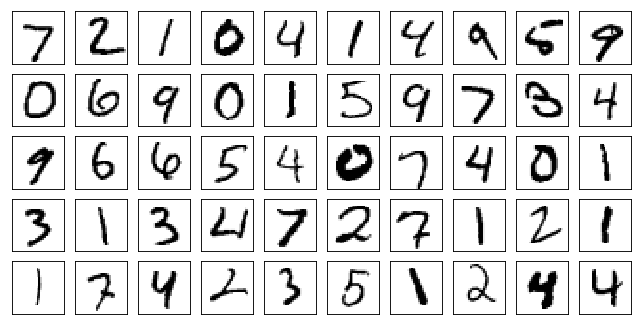

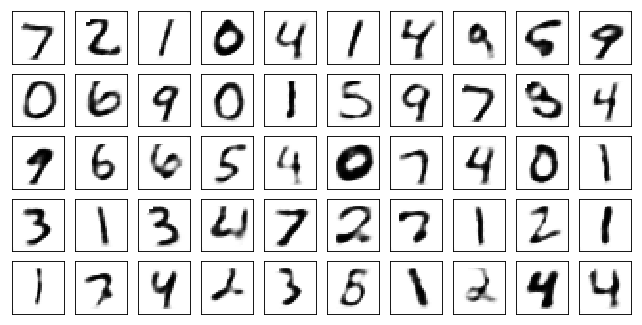

In [16]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))